[![Udacity - Self-Driving Car NanoDegree](https://s3.amazonaws.com/udacity-sdc/github/shield-carnd.svg)](http://www.udacity.com/drive) 
# Finding Lane Lines on the Road
http://www.udacity.com/drive

# How to read this notebook

This note book is sub divided into 3 Sections. 

Section I: This includes package import, understanding the problem boundaries.

Section II: Basic R&D to check pipeline components.

Section III: Lane Finding pipeline.


# Section I

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

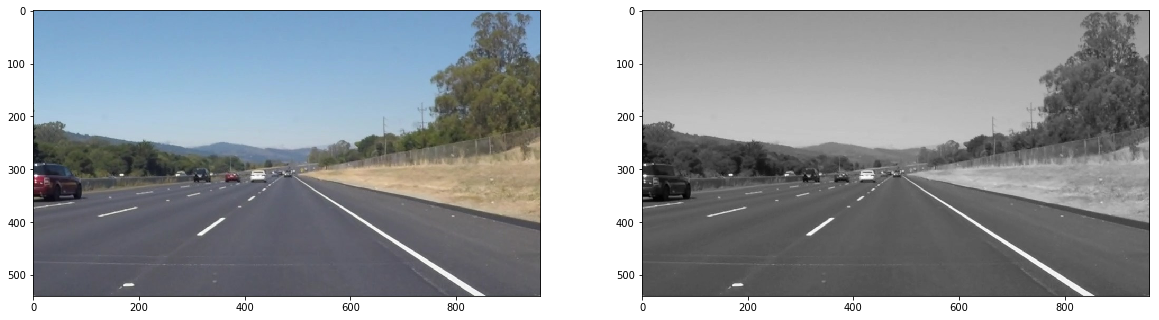

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) #grayscale conversion
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False,figsize=(20,20))
ax1.imshow(image)
ax2.imshow(gray,cmap='gray')

## Ideas for Lane Detection Pipeline

**OpenCV functions used for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.bitwise_and()` to apply a mask to an image
`cv2.bitwise_or()` to apply a mask to an image

In [3]:
import math
previous_frame_lines={} # this will hold the last good known cordinates of the left and right lines.

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=20):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    #for line in lines: #commented the basic line marking code
    #    for x1,y1,x2,y2 in line:
    #        cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    ##########################Making solid lines########################
    rm=[] #right slope
    lm=[] #right line center
    rc=[] #left slope
    lc=[] #left line center
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            if x2==x1:
                continue # ignore a vertical line
            if y1==y2:
                continue #ignore a horizontal line
            slope = (y2-y1)/(x2-x1)
            center=[(x2+x1)/2,(y2+y1)/2] 
            if slope < 0: # y is reversed in image
                lm.append(slope)
                lc.append(center)
            else:
                rm.append(slope)
                rc.append(center)
    #average over all right/left center,slope values to get single center and slope
    r_slope=np.sum(rm)/len(rm)
    l_slope=np.sum(lm)/len(lm)
    r_center=np.divide(np.sum(rc,axis=0),len(rc))
    l_center=np.divide(np.sum(lc,axis=0),len(lc))
    
    #leftlane
    if np.isnan(l_center).any():
            x1=previous_frame_lines['l_x1']
            x2=previous_frame_lines['l_x2']
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    else:
        previous_frame_lines.pop('l_x1', None)
        previous_frame_lines.pop('l_x2', None)
        y1=int(img.shape[0])
        x1=int(l_center[0] -(l_center[1]/l_slope) + (y1/l_slope))
        y2=int(img.shape[0]*.6)
        x2=int(l_center[0] -(l_center[1]/l_slope) + (y2/l_slope))
        #print(x1,y1,x2,y2)
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)
        previous_frame_lines['l_x1']=x1
        previous_frame_lines['l_x2']=x2
    
    #rightlane    
    if np.isnan(r_center).any():
        x1=previous_frame_lines['r_x1']
        x2=previous_frame_lines['r_x2']
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    else:
        previous_frame_lines.pop('r_x1', None)
        previous_frame_lines.pop('r_x2', None)
        y1=int(img.shape[0])
        x1=int(r_center[0] -(r_center[1]/r_slope) + (y1/r_slope))
        y2=int(img.shape[0]*.6)
        x2=int(r_center[0] -(r_center[1]/r_slope) + (y2/r_slope))
        #print(x1,y1,x2,y2)
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)
        previous_frame_lines['r_x1']=x1
        previous_frame_lines['r_x2']=x2
        #print('='*30)
        
    return None
    ####################################################################

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Eyeballing the images in different colorspaces 

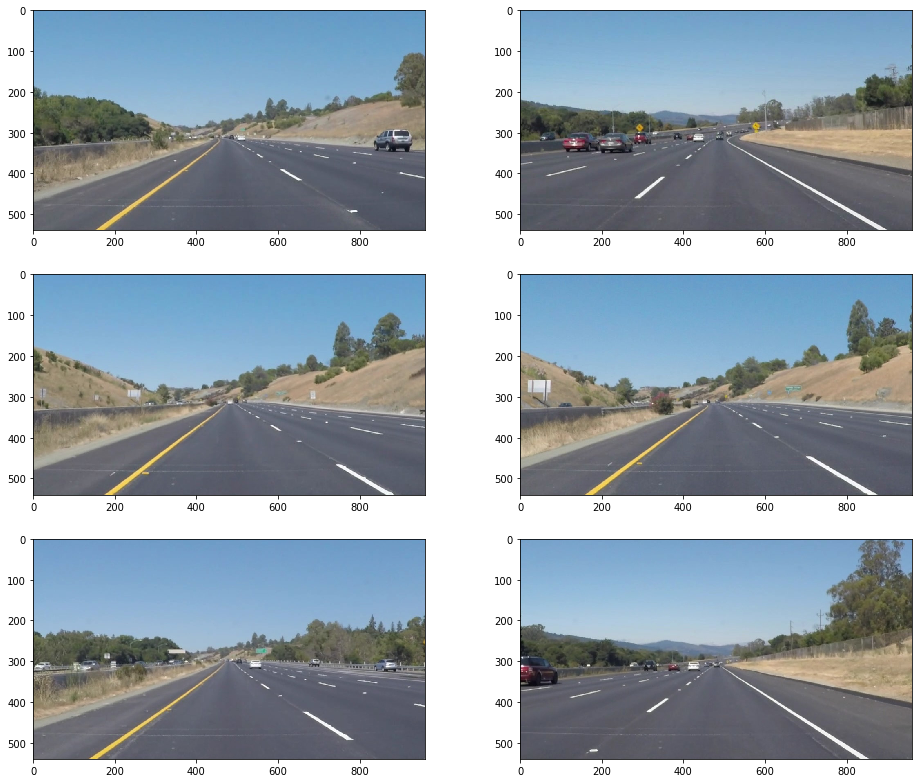

In [5]:
import os
imgfile_list=os.listdir("test_images/")
cols = 2
rows = (len(imgfile_list)+1)//cols

plt.figure(figsize=(16, 26))
for i, imagefilename in enumerate(imgfile_list):        
    image = mpimg.imread("test_images/"+imagefilename)    
    plt.subplot(rows, cols, i+1)
    plt.imshow(image)
plt.subplots_adjust(bottom=0.3, top=0.7, hspace=.2)
plt.show()

## All images are clear and bright

## Changing color space

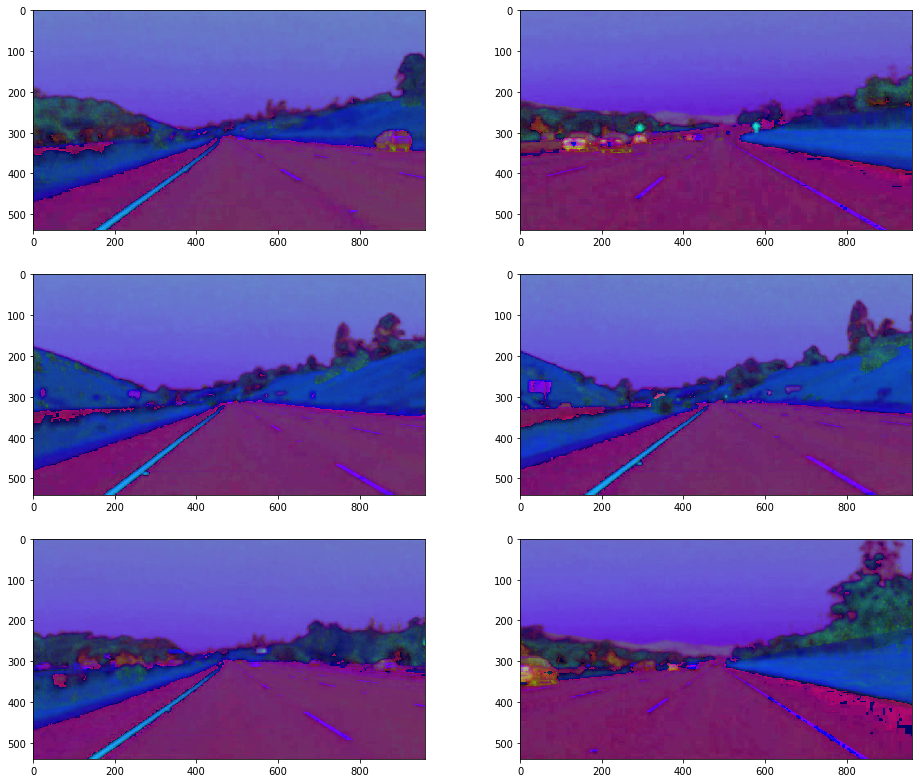

In [6]:
imgfile_list=os.listdir("test_images/")
cols = 2
rows = (len(imgfile_list)+1)//cols

plt.figure(figsize=(16, 26))
for i, imagefilename in enumerate(imgfile_list):        
    image = mpimg.imread("test_images/"+imagefilename)
    result=cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    plt.subplot(rows, cols, i+1)
    plt.imshow(result)
plt.subplots_adjust(bottom=0.3, top=0.7, hspace=.2)
plt.show()

# Section II

## Checking Gaussian Blur

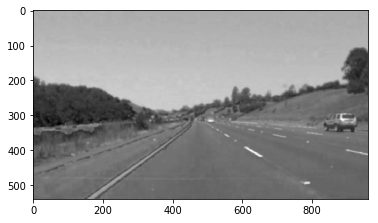

In [7]:
image = mpimg.imread("test_images/solidYellowCurve.jpg")
im=cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
gray = cv2.cvtColor(im,cv2.COLOR_RGB2GRAY)
blur_gray = cv2.GaussianBlur(gray, (9, 9), 0) #5,7,9,11
plt.imshow(blur_gray,cmap='gray')

## Checking ROI ( region of interest)

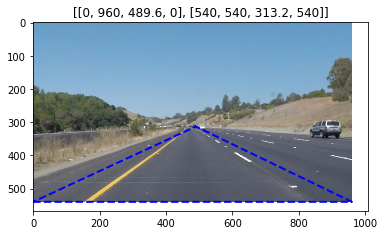

In [8]:
image = mpimg.imread("test_images/solidYellowCurve.jpg")
height=image.shape[0]
width=image.shape[1]
plt.imshow(image)
left_bottom=(0*width,1*height) #change the starting point to 10% and 90% 
right_bottom=(1*width,1*height)
left_top=(.51*width,.58*height) #%51% and 58% of weidth and height
right_top=(.49*width,.58*height)
 
x = [left_bottom[0], right_bottom[0], left_top[0], left_bottom[0]]
y = [left_bottom[1], right_bottom[1], right_top[1], left_bottom[1]]
plt.plot(x, y, 'b--', lw=2)
plt.title([x,y])
plt.show()

######### DONT RUN the Below Code everytime############
##based on above picture our apex point(guesstimate)
#(52% of width,60% of height) # right top
#(45% of width,60% of height) # left top  
#(10% of width,100% of height)# left bottom
#(90% of width,90% of height) #right bottom
# c=1
# ver={}
# for l in range(50,52,1):
#     for r in range(58,60,1):
#         image = mpimg.imread("test_images/frame51.jpg")
#         height=image.shape[0]
#         width=image.shape[1]
        
#         left_bottom=(.1*width,.9*height)
#         right_bottom=(.9*width,.9*height)
        
#         plt.imshow(image)
#         left_top=(l/100*width,r/100*height)
#         right_top=(l+20/100*width,r/100*height)
        
#         x = [left_bottom[0], right_bottom[0], left_top[0], left_bottom[0]]
#         y = [left_bottom[1], right_bottom[1], right_top[1], left_bottom[1]]
#         plt.plot(x, y, 'b--', lw=2)
#         plt.title([x,y])
#         plt.show()
#         #next image of diff size
#         image = mpimg.imread("test_images/solidWhiteRight.jpg")
#         height=image.shape[0]
#         width=image.shape[1]
        
#         left_bottom=(0.1*width,.9*height)
#         right_bottom=(.9*width,.9*height)

#         plt.imshow(image)
#         left_top=(l/100*width,r/100*height)
#         right_top=(l/100*width,r/100*height)
        
#         x = [left_bottom[0], right_bottom[0], left_top[0], left_bottom[0]]
#         y = [left_bottom[1], right_bottom[1], right_top[1], left_bottom[1]]
#         plt.plot(x, y, 'b--', lw=2)
#         plt.title([x,y])
#         plt.show()
        
#         print("Counter Number=>",c," ",l,r,x,y)
#         print('===========')        
#         ver[c]=left_top,right_top,left_bottom,right_bottom
#         c=c+1

## Basic object tracking using OpenCV masking technique 

Please see the below link for object tracking using OpenCV
http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_colorspaces/py_colorspaces.html

https://stackoverflow.com/questions/10948589/choosing-the-correct-upper-and-lower-hsv-boundaries-for-color-detection-withcv

In [9]:
white = np.uint8([[[255,255,255 ]]])
hsv_ = cv2.cvtColor(white,cv2.COLOR_BGR2HSV)
print(hsv_)

white = np.uint8([[[255,255,255 ]]])
hsv_ = cv2.cvtColor(white,cv2.COLOR_BGR2HLS)
print(hsv_)

white = np.uint8([[[255,255,0 ]]])
hsv_ = cv2.cvtColor(white,cv2.COLOR_BGR2HSV)
print(hsv_)

white = np.uint8([[[255,255,0 ]]])
hsv_ = cv2.cvtColor(white,cv2.COLOR_BGR2HLS)
print(hsv_)

[[[  0   0 255]]]
[[[  0 255   0]]]
[[[ 90 255 255]]]
[[[ 90 128 255]]]


## Testing lower and upper ranges

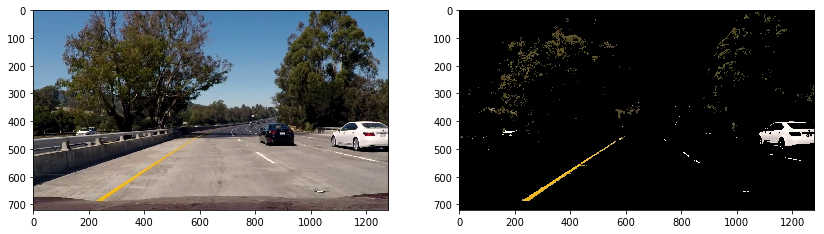

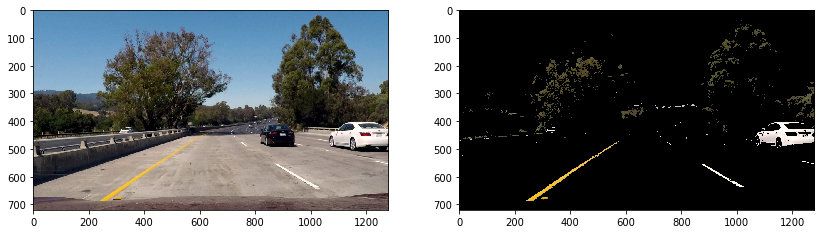

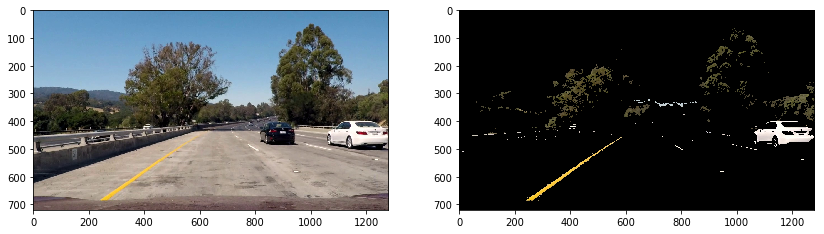

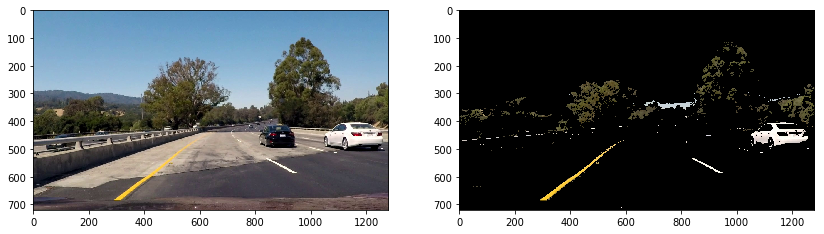

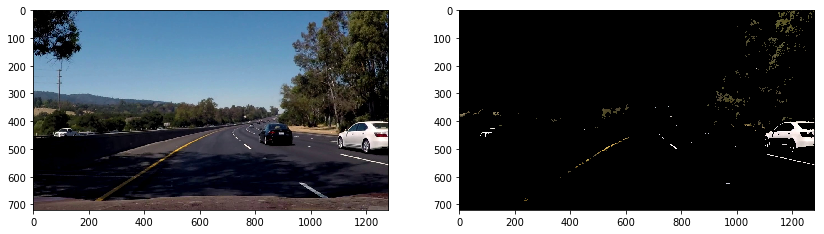

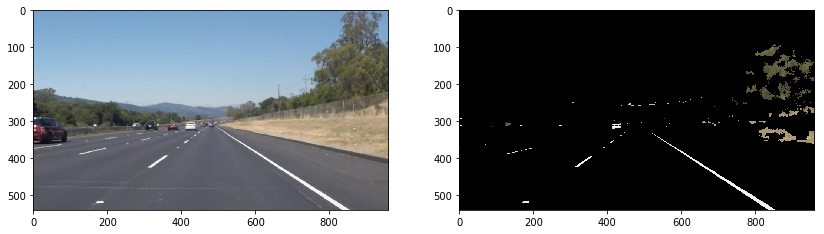

In [10]:
list__=['UntitledFolder/Frame128.jpg','UntitledFolder/Frame120.jpg',\
            'UntitledFolder/Frame113.jpg','UntitledFolder/Frame104.jpg',\
            'UntitledFolder/Frame156.jpg',"test_images/solidWhiteRight.jpg"]

for i in list__:
    image = mpimg.imread(i)
    converted = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # white color mask
    lower = np.array([  0, 0,   200])
    upper = np.array([255, 25, 255])
    white_mask = cv2.inRange(converted, lower, upper)

    # yellow color mask
    lower = np.array([ 20,  70, 70])
    upper = np.array([ 30, 255, 255])
    yellow_mask = cv2.inRange(converted, lower, upper)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    result=cv2.bitwise_and(image, image, mask = mask)

    f, (ax1, ax2) = plt.subplots(1, 2, sharey=False,figsize=(14,4))
    ax1.imshow(image)
    ax2.imshow(result)
    #break

# Section III

## Build a Lane Finding Pipeline



In [11]:
def find_lanes(image,kernel_size,low_threshold,high_threshold,rho,theta,\
               threshold,min_line_length,max_line_gap):
    
    converted = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # white color mask
    lower = np.array([  0, 0,   180]) #
    upper = np.array([255, 25, 255])
    white_mask = cv2.inRange(converted, lower, upper)

    # yellow color mask
    lower = np.array([ 20,  100, 100])
    upper = np.array([ 30, 255, 255])
    yellow_mask = cv2.inRange(converted, lower, upper)

    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    result=cv2.bitwise_and(image, image, mask = mask)

    gray = cv2.cvtColor(result,cv2.COLOR_RGB2GRAY) # processing the masked image

    #using gaussian blur method to smooth out  
    blur_gray = gaussian_blur(gray,kernel_size)

    #using canny method to find edges
    edges = canny(blur_gray, low_threshold, high_threshold)

    #narrowing the vision to lanes only
    imshape = image.shape
    height=image.shape[0]
    width=image.shape[1]

    #(52% of width,60% of height) # right top to start with...
    #(45% of width,60% of height) # left top  
    #(10% of width,100% of height)# left bottom
    #(90% of width,90% of height) #right bottom
    left_bottom=(0.*width,.9*height)
    right_bottom=(1.*width,.9*height)
    left_top=(.50*width,.58*height)
    right_top=(.50*width,.58*height)
    vertices = np.array([[(left_top),(right_top),(left_bottom),(right_bottom)]], dtype=np.int32)
    masked_edges=region_of_interest(edges,vertices)

    # Define the Hough transform parameters
    line_image=hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)

    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges)) 

    # Draw the lines on the edge image    
    lines_edges=weighted_img(line_image, image, α=0.8, β=1., γ=0.)

    return [image,gray,edges,masked_edges,line_image,lines_edges]

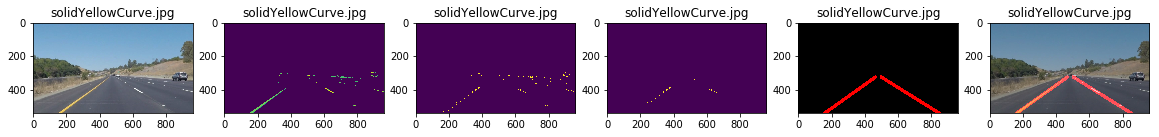

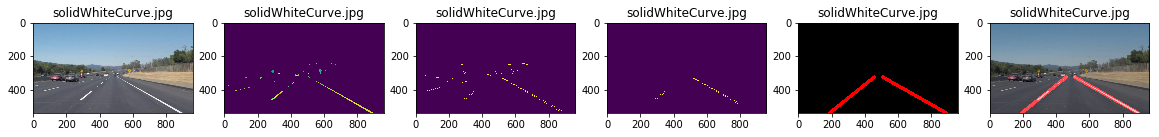

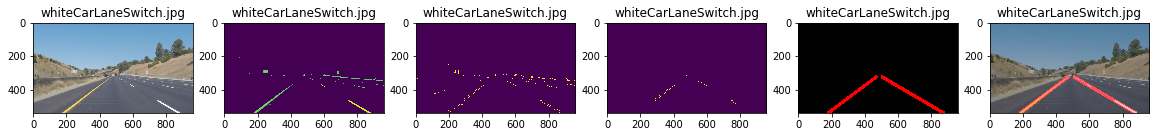

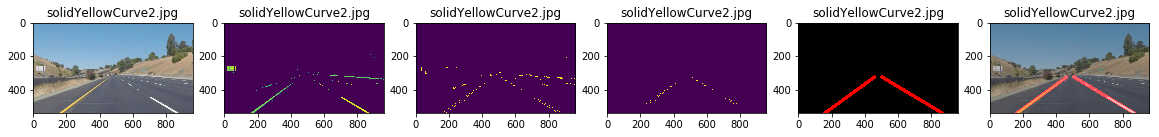

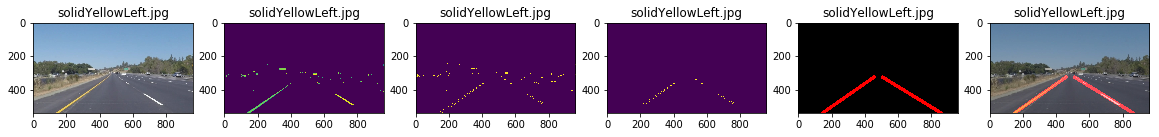

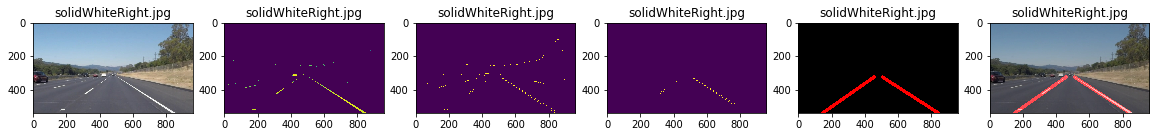

In [12]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
imgfile_list=os.listdir("test_images/")

kernel_size=5
low_threshold = 50
high_threshold = 190    
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 32     #minimum number of votes (intersections in Hough grid cell)
min_line_length = 5 #minimum number of pixels making up a line
max_line_gap = 150    #maximum gap in pixels between connectable line segments   

for imagefilename in imgfile_list:    
    plt.figure(figsize=(20,10))
    columns = 6
    image = mpimg.imread("test_images/"+imagefilename) 
    for i, img in enumerate(find_lanes(image,kernel_size,\
                                       low_threshold,high_threshold,rho,theta,\
                                       threshold,min_line_length,max_line_gap)):
        plt.subplot(6 / columns + 1, columns, i + 1)
        plt.imshow(img)
        plt.title(imagefilename)
        plt.savefig("test_images_output/"+imagefilename)
        plt.imshow(img)
plt.subplots_adjust(bottom=0.3, top=0.7, hspace=.2)
plt.show()

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [13]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [14]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    kernel_size=5
    low_threshold = 50
    high_threshold = 190    
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 32     #minimum number of votes (intersections in Hough grid cell)
    min_line_length = 5 #minimum number of pixels making up a line
    max_line_gap = 150    #maximum gap in pixels between connectable line segments   

    result=find_lanes(image,kernel_size,\
                                       low_threshold,high_threshold,rho,theta,\
                                       threshold,min_line_length,max_line_gap)[5] #last image is considered

    return result

Let's try the one with the solid white lane on the right first ...

In [15]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:14<00:00, 15.66it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 3.92 s, sys: 172 ms, total: 4.09 s
Wall time: 15.8 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [17]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:48<00:00, 14.13it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 12.1 s, sys: 711 ms, total: 12.9 s
Wall time: 49.9 s


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

## Extraction of few frames from Challenge video 

In [19]:
#This steup is done only to get few frames from the challlenge video for testing the pipeline
vidcap = cv2.VideoCapture('test_videos/challenge.mp4')
success,image = vidcap.read()
count = 0
success = True
while success:
  cv2.imwrite("UntitledFolder/Frame%d.jpg" % count, image)     # save frame as .JPG file      
  success,image = vidcap.read()
  count += 1

In [20]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(.11,.27)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:33<00:00,  7.59it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 7.57 s, sys: 368 ms, total: 7.93 s
Wall time: 36.4 s


In [21]:
challenge_output = 'test_videos_output/challenge.mp4'
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))